---
# **1. DESCRIPTION OF THE IDEA FOR THE TASK**
---


Th idea of the analysis was born after a careful review of relevant literature (see summary word doc in repo) of anomaly detection, prediction and an article ["Open Challenges in Time Series Anomaly Detection: An Industry Perspective"](https://arxiv.org/abs/2502.05392) published by Microsoft where the real challenges practitioners face while implementing models into system were explained. 


In the article ["Predicting  SLA Violations in Real Time using Online Machine Learning"](https://arxiv.org/abs/1509.01386) the authors address the challenge of ensuring real-time service quality in telecom environments, which is increasingly complex as services migrate to the cloud.

### Problem: offline limitations

1. **Core challenge:** service assurance systems must detect and predict Service Level Agreement (SLA) violations to prevent business and reputation loss.

2. **Predictive difficulty:** predicting these violations is difficult because user demands and infrastructure loads change over time.

3. **Concept drift:** traditional offline machine learning assumes data is drawn from a stationary distribution (it doesn't change). In reality, this distribution evolves. This is called "concept drift" which causing offline models trained on old data to become inaccurate as system behavior changes.

4. **Goal:** to predict application-level SLA (whether the service quality is "violated" or "not violated") based on server-side device statistics ($X$), even when the underlying data distribution changes over time.

### Proposed solution: online machine learning

1. **Service agnostic approach:** authors propose an online learning method that learns system behavior "on the fly" from a continuous stream of data.

2. **Streaming metrics:** system uses low-level device metrics ( CPU usage, free memory, context switches, else...) collected at the server to predict client-side performance.

3. **Incremental learning:** unlike offline methods that require a separate, static training phase, online method gradually improves its understanding as new data arrives.

4. **Effectiveness:** results demonstrate that online methods—specifically the Online Accuracy Update Ensemble (OAUE)—can achieve over 90% classification accuracy and maintain high performance even when load patterns change abruptly

### Researchers do real-time detection: 
Prediction of a binary state (SLA violated vs. not violated) at the current moment in real-time. It aims to determine if the current server statistics ($X$) imply that the client is currently experiencing a quality drop.

### What I do in my analysis:

I try to predict future incidents using a lead-time horizon ($H$). Specifically, I use previous $W$ seconds of server metrics to predict whether an incident will occur at least once in the next $H$ seconds. 



---
# **2. DESCRIPTION OF THE DATA**
---

### **Dataset: Linux kernel statistics from a video server and service metrics from a video client**

**Sourse:** [dataset](https://mldata-static.ml.tu-berlin.de/repository/data/viewslug/realm-im2015-vod-traces/index.html)


The dataset consists of 21 specific server metrics matched against video quality measurements taken every second. It is built to show how server stress directly causes video lag. This dataset is well-suited for **incident prediction** because it links server-side statistics to user-visible degradation events. It contains synchronized time series sampled every second (1 Hz) from a video-on-demand service:

1. **Server metrics: $𝑋$** 21 Linux/kernel (SAR-style) system metrics describing server load and resource usage (CPU, memory, process activity, network-related counters, else...).

2. **Client QoS $𝑌$**: service-quality measurements from the video client, including **FPS (frame rate)** and **ABS (audio buffer-related metric)**.

3. **Incident or label**: we define an **incident** as a QoS/SLO violation when **FPS < 20 (optionally also ABS < 20)**. For a given task I construct a sliding-window dataset where each example uses the previous **$𝑊$** seconds of server metrics to predict whether an incident will occur at least once in the next 
**$H$** seconds.
















### **2.1. Import packages**
---

In [1]:
# packages for dealing with data
from __future__ import annotations
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# my helpers
from helpers import *
from online_methods import *

# packages for modelling offline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_fscore_support, balanced_accuracy_score

# packages for modelling online
from collections import deque
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

### **2.2. Inspect the structure of the data**
---

Download data

In [2]:
# directory
root = Path(r"C:\Users\oleks\Desktop\jetbrain\data")

def load_all(folder):
    """
    Function is looking for any subfolder with cvs files, reads them, 
    and put them into DataFrame.
    Adds columns to track which folder and file the data came from.
    """
    files = list((root / folder).rglob("*.csv"))
    return pd.concat(
        [pd.read_csv(f).assign(dataset=folder, file=f.stem) for f in files],
        ignore_index=True
    )

X_PROC = load_all("X_PROC")
X_SAR  = load_all("X_SAR")

print(X_PROC.shape, X_SAR.shape)

(139084, 4589) (225564, 871)


All data are in cvs format and structured as shown in summary below. Since the number of NA is very low is assumed that they do not have any significant impact on analysis. It was decided to proceed without imputing missing data. 

In [3]:
files = sorted(root.rglob("*.csv"))

rows = []
for f in files:
    df = pd.read_csv(f)
    # count NA
    na = df.isna().sum().sum()
    rows.append({
        "file": str(f.relative_to(root)),
        "rows": df.shape[0],
        "cols": df.shape[1],
        "na_cells": int(na),
        "na_%": float(na / df.size) if df.size else 0.0,
    })

# show summary
summary = pd.DataFrame(rows).sort_values(["file"])
summary

,file,rows,cols,na_cells,na_%
0,X_PROC\constant_load\X.csv,16964,4571,0,0.000000
1,X_PROC\constant_load\Y.csv,16964,16,0,0.000000
2,X_PROC\flashcrowd_load\X.csv,12096,4571,0,0.000000
3,X_PROC\flashcrowd_load\Y.csv,12096,16,0,0.000000
4,X_PROC\linear_increase\X.csv,16447,4571,0,0.000000
5,X_PROC\linear_increase\Y.csv,16447,16,0,0.000000
6,X_PROC\periodic_load\X.csv,12023,4571,0,0.000000
7,X_PROC\periodic_load\Y.csv,12023,16,0,0.000000
8,X_PROC\poisson_load\X.csv,12012,4571,0,0.000000
9,X_PROC\poisson_load\Y.csv,12012,16,0,0.000000


Check the columns and make a report with the names of the columns in order to choose the ones for modelling

In [4]:
# define how data are stored
sources = ["SAR", "PROC"]
types = ["X", "Y"]
scenarios = ["constant_load", "flashcrowd_load", "linear_increase", "periodic_load", "poisson_load"]

dfs = {}

# iterate over sources and types
for src, t in product(sources, types):
    var_name = f"X_{src}_{t}"
    # for each scenario, find cvs's and collect them
    dfs[var_name] = pd.concat(
        [pd.read_csv(root / f"X_{src}" / s / f"{t}.csv").assign(scenario=s) for s in scenarios],
        ignore_index=True
    )
    # print first 5 from each scenario
    print(f"{var_name} columns: {dfs[var_name].columns.tolist()[:5]}")


# save the report with names columns 
with open("1_EDA_all_columns.txt", "w") as f:
    for name, df in dfs.items():
        f.write(f"----------- {name} Columns -----------\n")
        # every single column name for a given dataset
        f.write("\n".join(df.columns.tolist()))
        f.write("\n" * 20) 
    print("The whole report was saved in current repository:) ")

X_SAR_X columns: ['TimeStamp', 'all_%%usr', 'all_%%nice', 'all_%%sys', 'all_%%iowait']
X_SAR_Y columns: ['TimeStamp', 'LostFrames', 'noAudioPlayed', 'noAudioPlayedAvg2', 'noAudioPlayedAvg5']
X_PROC_X columns: ['Time stamp (system)', '/proc/buddyinfo_line_3_value11', '/proc/buddyinfo_line_3_value10', '/proc/buddyinfo_line_3_node_number', '/proc/buddyinfo_line_1_node_number']
X_PROC_Y columns: ['TimeStamp', 'LostFrames', 'noAudioPlayed', 'noAudioPlayedAvg2', 'noAudioPlayedAvg5']
The whole report was saved in current repository:) 


### **2.3. Plot some variables**
---

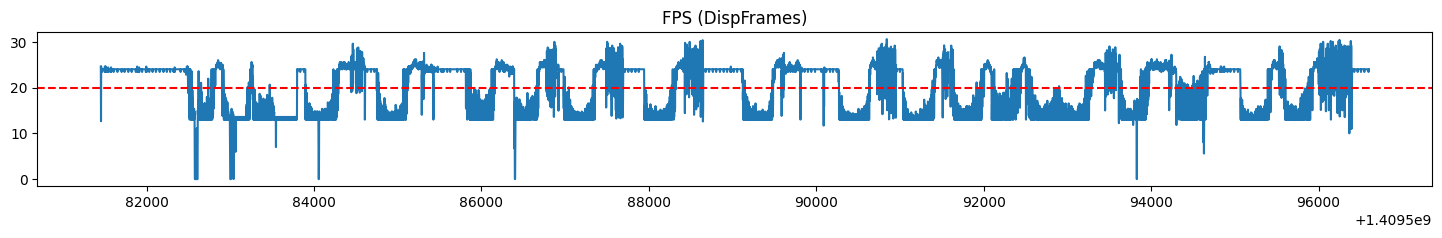

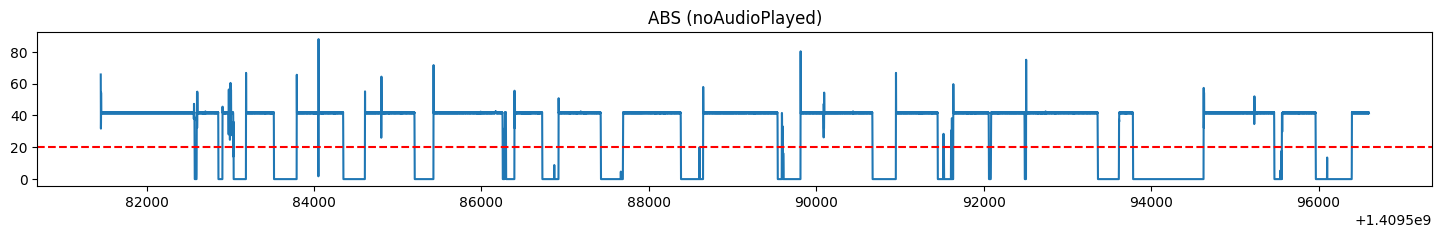

(-0.1, 1.1)

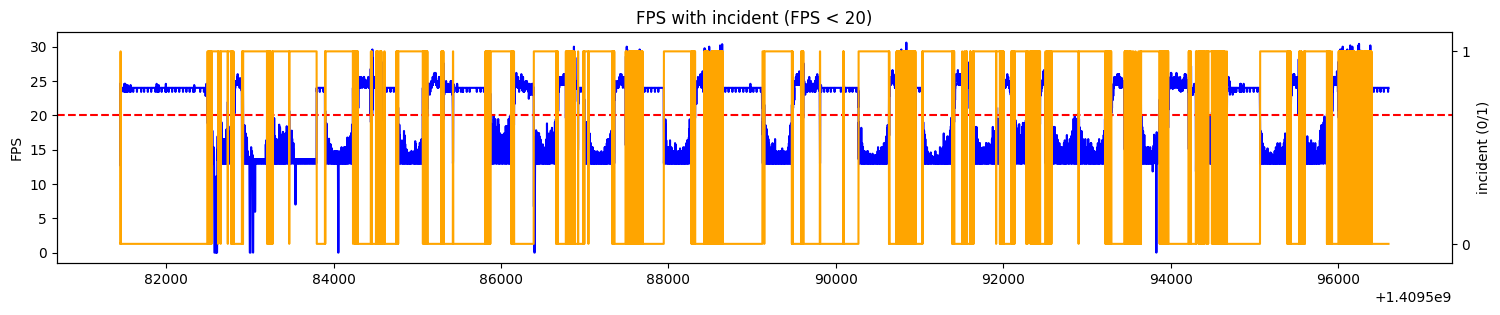

In [5]:
scenario = "flashcrowd_load"

# prepare data for plotting
X = extract_variables(root / "X_SAR" / scenario / "X.csv")
Y = pd.read_csv(root / "X_SAR" / scenario / "Y.csv")[["TimeStamp", "DispFrames", "noAudioPlayed"]]
# comparing server stress and app performance
df = X.merge(Y, on="TimeStamp", how="inner")

# plot user experience
plt.figure(figsize=(18, 2))  
plt.plot(df["TimeStamp"], df["DispFrames"])
plt.axhline(20, color='red', linestyle='--')
plt.title("FPS (DispFrames)")
plt.show()

# plot audio drops
plt.figure(figsize=(18, 2))
plt.plot(df["TimeStamp"], df["noAudioPlayed"])
plt.axhline(20, color='red', linestyle='--') # threshold
plt.title("ABS (noAudioPlayed)")
plt.show()


# here 1 = an app is freezing, 0 = all fine
t = df["TimeStamp"]
fps = df["DispFrames"]
incident = (fps < 20).astype(int)
fig, ax1 = plt.subplots(figsize=(18, 3))
# blue FPS here is actual dropping in performance
ax1.plot(t, fps, color='blue')  
ax1.axhline(20, color='red', linestyle='--')  # threshold
ax1.set_title("FPS with incident (FPS < 20)")
ax1.set_ylabel("FPS")
# orange are incident blocks
ax2 = ax1.twinx()
ax2.plot(t, incident, color='orange')  
ax2.set_ylabel("incident (0/1)")
ax2.set_yticks([0, 1])
ax2.set_ylim(-0.1, 1.1)


1. **Plot DispFrames:** every time that blue line goes below red dotted one, the user is seeing poor performance of a video. 

2. **Plot noAudioPlayed:** when blue line is at 40, the audio has stopped because the system is too stressed (buffer exhaustion). When the blue line is at 0, then the audio is playing well. 

3. **FPS:** here cause and effect is shown: blue line is FPS and orange is binary incident (0 or 1). When orange line is 1, the blue line is below the red dashed line which explains poor performance. 

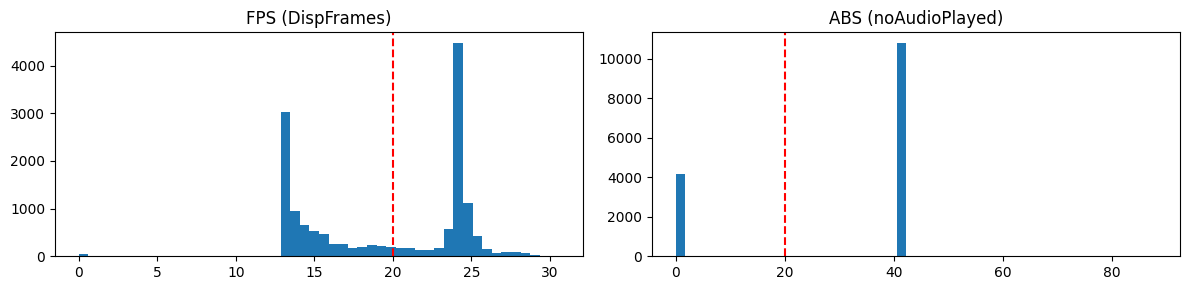

In [6]:
# 2 plots in 1 row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# plot 1: video quality distribution
ax1.hist(Y["DispFrames"].dropna(), bins=50)
ax1.axvline(20, color='red', linestyle='--')
ax1.set_title("FPS (DispFrames)")

# plot 2: Video good = 0 and poor = 40 distribution
ax2.hist(Y["noAudioPlayed"].dropna(), bins=50)
ax2.axvline(20, color='red', linestyle='--')
ax2.set_title("ABS (noAudioPlayed)")

plt.tight_layout()
plt.show()

1. **FPS (DispFrames)** Above 20 part of a histogram is good performance while below 20 is poor. 

2. **ABS (noAudioPlayed)** At 0 every video was playing well. At 40 it fails (like audio stream is droppedto save resources)

---
# **3. PROBLEM FORMULATION**
---

The objective is to predict whether a system failure will occur within a future horizon of $𝐻$ seconds based on the most recent $𝑊$ observations of system metrics.

For each sliding window, summary statistics are computed per metric:

- mean,

- standard deviation,

- minimum,

- maximum,

- last observed value.

This transforms each window into a fixed-length vector, so that ML can be used. Following the methodology discussed in the reference paper, two learning paradigms are investigated:

1. Offline Learning: (i) models are trained once on the training data, (ii) decision threshold is selected on the validation set under a false positive rate  constraint, (iii) performance is evaluated on the unseen test set.

2. Online Learning (i) models updated as new windows arrive, (ii) performance is evaluated on validation and test segments while allowing model updates.

**EVALUATION** 
Given the relevant papers, next metrics were chosen:

PR-AUC (ranking quality under class imbalance),

Precision (alert reliability),

Recall (incident coverage),

F1-score,

Balanced Accuracy,

False Positive Rate, with constraint (≤ 1%).


---
# **4. MODEL: OFFLINE IMPLEMENTATION**
---

### **4.1. Make windows**

Window size was defines as 60 seconds

Horizon size was defined as 30 seconds



In [7]:
# define window size
W, H = 60, 30
scenario = "flashcrowd_load"
X_windows, y, t_idx = make_task_dataset(root, scenario, W=W, H=H)

# define train, validate, test sets
train_idx, val_idx, test_idx = time_split_indices(len(y))

# reshape features into needed format
X2 = summary_features(X_windows)  

X_train, y_train = X2[train_idx], y[train_idx]
X_val,   y_val   = X2[val_idx],   y[val_idx]
X_test,  y_test  = X2[test_idx],  y[test_idx]

t_test = t_idx[test_idx]  # forplots later on 

### **4.2. Define which models to choose and train them**

In accordance with ["Predicting  SLA Violations in Real Time using Online Machine Learning"](https://arxiv.org/abs/1509.01386) paper's narrative, logistic regression and random forest have shown good results so that for this task it was decided to chose these models. The second reason is that I use the same dataset as in the paper and I do believe taht researchers were trying with different models before choosing the best ones.

In [8]:
# train logistic regression
lr = make_pipeline(StandardScaler(), LogisticRegression(class_weight="balanced", max_iter=1000))
lr.fit(X_train, y_train)
p_val_lr = lr.predict_proba(X_val)[:, 1]

# train random forest
rf = RandomForestClassifier(class_weight="balanced_subsample", random_state=0)
rf.fit(X_train, y_train)
p_val_rf = rf.predict_proba(X_val)[:, 1]

### **4.3. Validate, train, discuss results**
---

In [9]:
# validation 
X_val, y_val = X2[val_idx], y[val_idx]
p_val_lr = lr.predict_proba(X_val)[:, 1]
p_val_rf = rf.predict_proba(X_val)[:, 1]

thr_lr = choose_threshold_fpr_cap(p_val_lr, y_val, fpr_cap=0.01)
thr_rf = choose_threshold_fpr_cap(p_val_rf, y_val, fpr_cap=0.01)

# test 
X_test, y_test = X2[test_idx], y[test_idx]

p_test_lr = lr.predict_proba(X_test)[:, 1]
p_test_rf = rf.predict_proba(X_test)[:, 1]

thr_lr = choose_threshold_fpr_cap(p_val_lr, y_val, fpr_cap=0.01)
thr_rf = choose_threshold_fpr_cap(p_val_rf, y_val, fpr_cap=0.01)

res_lr = evaluate_simple(p_test_lr, y_test, thr_lr)
res_rf = evaluate_simple(p_test_rf, y_test, thr_rf)


In [10]:
# logistic regression 
# val
pr_auc_val_lr, prec_val_lr, rec_val_lr, f1_val_lr, ba_val_lr = evaluate_simple(p_val_lr, y_val, thr_lr)
fpr_val_lr = fpr_at_threshold(p_val_lr, y_val, thr_lr)
# test
pr_auc_test_lr, prec_test_lr, rec_test_lr, f1_test_lr, ba_test_lr = evaluate_simple(p_test_lr, y_test, thr_lr)
fpr_test_lr = fpr_at_threshold(p_test_lr, y_test, thr_lr)


# offline random forest results
# val
pr_auc_val_rf, prec_val_rf, rec_val_rf, f1_val_rf, ba_val_rf = evaluate_simple(p_val_rf, y_val, thr_rf)
fpr_val_rf = fpr_at_threshold(p_val_rf, y_val, thr_rf)
# Test
pr_auc_test_rf, prec_test_rf, rec_test_rf, f1_test_rf, ba_test_rf = evaluate_simple(p_test_rf, y_test, thr_rf)
fpr_test_rf = fpr_at_threshold(p_test_rf, y_test, thr_rf)


# 
def fmt(val):
    return f"{val:.4f}"

# --- Print header ---
print("\n" + "="*70)
print("OFFLINE MODEL COMPARISON: LOGISTIC REGRESSION vs RANDOM FOREST")
print("="*70)
print(f"{'Metric':<25} {'Logistic Regression':>22} {'Random Forest':>22}")
print("-"*70)

# --- Validation rows ---
print(f"{'Validation:':<25} {'':>22} {'':>22}")
print(f"{'  PR-AUC (prob)':<25} {fmt(pr_auc_val_lr):>22} {fmt(pr_auc_val_rf):>22}")
print(f"{'  Precision':<25} {fmt(prec_val_lr):>22} {fmt(prec_val_rf):>22}")
print(f"{'  Recall':<25} {fmt(rec_val_lr):>22} {fmt(rec_val_rf):>22}")
print(f"{'  F1':<25} {fmt(f1_val_lr):>22} {fmt(f1_val_rf):>22}")
print(f"{'  FPR':<25} {fmt(fpr_val_lr):>22} {fmt(fpr_val_rf):>22}")
print(f"{'  Balanced Acc.':<25} {fmt(ba_val_lr):>22} {fmt(ba_val_rf):>22}")
print(f"{'  Threshold used':<25} {fmt(thr_lr):>22} {fmt(thr_rf):>22}")
print()

# --- Test rows ---
print(f"{'Test:':<25} {'':>22} {'':>22}")
print(f"{'  PR-AUC (prob)':<25} {fmt(pr_auc_test_lr):>22} {fmt(pr_auc_test_rf):>22}")
print(f"{'  Precision':<25} {fmt(prec_test_lr):>22} {fmt(prec_test_rf):>22}")
print(f"{'  Recall':<25} {fmt(rec_test_lr):>22} {fmt(rec_test_rf):>22}")
print(f"{'  F1':<25} {fmt(f1_test_lr):>22} {fmt(f1_test_rf):>22}")
print(f"{'  FPR':<25} {fmt(fpr_test_lr):>22} {fmt(fpr_test_rf):>22}")
print(f"{'  Balanced Acc.':<25} {fmt(ba_test_lr):>22} {fmt(ba_test_rf):>22}")
print(f"{'  Threshold used':<25} {fmt(thr_lr):>22} {fmt(thr_rf):>22}")
print("="*70)


OFFLINE MODEL COMPARISON: LOGISTIC REGRESSION vs RANDOM FOREST
Metric                       Logistic Regression          Random Forest
----------------------------------------------------------------------
Validation:                                                            
  PR-AUC (prob)                           0.8334                 0.8598
  Precision                               0.9720                 0.9812
  Recall                                  0.1980                 0.2977
  F1                                      0.3290                 0.4568
  FPR                                     0.0084                 0.0084
  Balanced Acc.                           0.5948                 0.6447
  Threshold used                          0.9887                 0.6700

Test:                                                                  
  PR-AUC (prob)                           0.5118                 0.6002
  Precision                               0.4764                 0.9605


Under careful literature review (see summary.doc) it was decided to use next metrics for model evaluation: 

1. Precision–Recall Area Under Curve

2. Precision

3. Recall 

4. F1 Score

5. Balanced Accuracy

6. False Positive Rate

**RECAP** Starting from a time-series, a sliding-window dataset was constructed. Each example uses the last **W = 60** seconds of system metrics as input. The label is 1 if any incident (drop in the flashcrowd_load variable below 15) occurs in the next **H = 30** seconds, otherwise 0. For each window summary features were computed (mean, std, min, max, last value per metric) and model was trained on them. The windows were split: (i) 70% train, (ii) 15% validate, (iii) 15% test. The threshold is false positive rate ≤ 1% was chosen. Two models were trained on the training windows only. Time series is not assumed to be stationary. The models themselves treat each window as a sample. Models were trained on past windows and test on future windows.

**RESULTS DISCUSSION** While observing the results on test dataset, Logistic regression achieves reasonable recall, but at the cost of an enormous false-positive rate which makes this model unsuitable. In terms of random forest, it almost never raises false alarms, but it misses drop of quality incidents. Both models are unsuitable. 

To take things further, it was proved that the reasons behind poor quality of the models are:

- **offline models assume data comes from a stationary distribution.**

- in real life, system load changes which makes concept drift.

- when you train offline on one trace and test on another, performance is poor

Offline models trained once cannot be trusted under changing load conditions. That is exactly what I observe in my case: 

(i) train once on past data and fix a model, 

(ii) fit the model, 

(iii) evaluate on future data 

(iv) poor performance.

---
# **5. ONLINE MODEL IMPLEMENTATION**
---



### **5.1. Define models and split data as offline**
---

Given the limitations observed in the offline models and the non-stationary nature of system monitoring data, online learning methods were investigated.

**PREPROCESSING STEPS:** 

- Sliding window W = 60, prediction horizon H = 30 were used as in offline methods.

- Here each window is one training sample.

- For every window, online model predicts whether an incident will happen in the future window. (early warning prediction of a drop in the flashcrowd_load variable below 15)

- For each window, summary statistics were computed: mean, standard deviation, minimum val, maximum value

- The dataset was split: 70% train, 15% val, 15% test, without shuffling since time order should be original.

- Val and test sets were combined into one evaluation stream for prequential testing.

**METHODS**

1. Prequential (predict and update) evaluation was used. Was used due to the fact that model never sees the future and it reflect true online behavior. For each sample in evaluation stream:

- predict probability

- convert probability to binary decision using adaptive threshold

- update model using true label

- update adaptive threshold

2. Adaptive Threshold = adjust to concept drift in real time (we want to keep false positive rate close to 1% )

- remember recent binary decisions and true labels.

- calculate rolling false positive rate

- If false positive rate high then threshold up = strict evaluation

- If false positive rate low threshold down = less strict option

3. Online training

- Model updates after every new sample.

- No retraining from scratch.

- Model learns all the time.

**MODELS USED**

1. Online Logistic Regression

2. OAUE-like Ensemble

 - each tree predicts.

- trees are evaluated by recent accuracy.

- if accuracy of a tree is bad (< 0.55), it is replaced by a new one.

- peplaced tree is trained on current sample.

**THE IDEA BEHIND**

Offline training: first 70% of data used to initialize models. After that, online phase, for each new sample: (i) predict, (ii) update model, (iii) update adaptive threshold so that the model continuously learns cause data arrives sequentially.

In [ ]:
# build dataset from helper functions
W, H = 60, 30
scenario = "flashcrowd_load"

# sliding‑window samples: X_windows = (N, W, n_features), y = (N,)
X_windows, y, t_idx = make_task_dataset(root, scenario, W=W, H=H)
# compute summary statistics mean, std, min, max, last over each window
X_features = summary_features(X_windows)
# split data into train 70%, validation(15%, test 15% in time order
train_idx, val_idx, test_idx = time_split_indices(len(y))
# training data
X_train, y_train = X_features[train_idx], y[train_idx]
# for prequential evaluation make single stream from validation and test
eval_idx = np.concatenate([val_idx, test_idx])
X_eval, y_eval = X_features[eval_idx], y[eval_idx]
t_eval = t_idx[eval_idx]            # time for plotting
n_val = len(val_idx)                # nr of validation sample
# mask to extract only test set from evaluation stream
val_mask = np.arange(len(eval_idx)) < n_val
# true labels of test set
y_test = y_eval[~val_mask]



# online logistic regression (via SGDClassifier)
lr_results = evaluate_online_prequential(
    X_train=X_train,
    y_train=y_train,
    X_eval=X_eval,
    y_eval=y_eval,
    timestamps=t_eval,
    model_class=SGDClassifier,
    model_params={},
    fpr_target=0.01,            # threshold for false positive rate
    window_size=200,            # window=200 for adaptive threshold
    initial_threshold=0.5,      # start adaptive threshold=0.5
    adjustment_factor=1.03,     # aggresive adaptive threshold or not
)

# probabilities and binary decisions from online log reg
p_eval_lr = lr_results["probabilities"]
yhat_eval_lr = lr_results["binary_predictions"]
# test set for final evaluation
p_test_lr = p_eval_lr[~val_mask]
yhat_test_lr = yhat_eval_lr[~val_mask]

# threshold metrics (probabilities, prequential)
pr_auc_lr = average_precision_score(y_test, p_test_lr)
roc_auc_lr = roc_auc_score(y_test, p_test_lr)

# online thresholded metrics (binary_predictions directly)
precision_lr = precision_score(y_test, yhat_test_lr, zero_division=0)
recall_lr = recall_score(y_test, yhat_test_lr, zero_division=0)
f1_lr = f1_score(y_test, yhat_test_lr, zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_test_lr, labels=[0, 1]).ravel()
fpr_lr = fp / (fp + tn) if (fp + tn) > 0 else 0.0



# OAUE Ensemble
oaue_results = evaluate_online_prequential(
    X_train=X_train,
    y_train=y_train,
    X_eval=X_eval,
    y_eval=y_eval,
    timestamps=t_eval,
    model_class=OAUEEnsemble,
    model_params={
        "n_estimators": 20,
        "grace_period": 100,
        "delta": 1e-2,
        "tau": 0.05,
        "acc_init": 0.75,
        "acc_min": 0.55,
        "acc_window_size": 200,
        "vote_temperature": 5.0,
    },
    fpr_target=0.01,
    window_size=200,
    initial_threshold=0.5,
    adjustment_factor=1.03,
)

# well, same code as for log reg
p_eval_oa = oaue_results["probabilities"]
yhat_eval_oa = oaue_results["binary_predictions"]

p_test_oa = p_eval_oa[~val_mask]
yhat_test_oa = yhat_eval_oa[~val_mask]

pr_auc_oa = average_precision_score(y_test, p_test_oa)
roc_auc_oa = roc_auc_score(y_test, p_test_oa)

precision_oa = precision_score(y_test, yhat_test_oa, zero_division=0)
recall_oa = recall_score(y_test, yhat_test_oa, zero_division=0)
f1_oa = f1_score(y_test, yhat_test_oa, zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_test_oa, labels=[0, 1]).ravel()
fpr_oa = fp / (fp + tn) if (fp + tn) > 0 else 0.0

In [ ]:
# make nice table 
def fmt(val):
    return f"{val:.4f}"

print("\n" + "="*70)
print("ONLINE MODEL COMPARISON: LOGISTIC REGRESSION vs OAUE‑LIKE ENSEMBLE")
print("="*70)
print(f"{'Metric':<35} {'Logistic Regression':>20} {'OAUE Ensemble':>20}")
print("-"*70)

print(f"{'PR-AUC (probabilities)':<35} {fmt(pr_auc_lr):>20} {fmt(pr_auc_oa):>20}")
print(f"{'ROC-AUC (probabilities)':<35} {fmt(roc_auc_lr):>20} {fmt(roc_auc_oa):>20}")
print(f"{'Precision (online decisions)':<35} {fmt(precision_lr):>20} {fmt(precision_oa):>20}")
print(f"{'Recall (online decisions)':<35} {fmt(recall_lr):>20} {fmt(recall_oa):>20}")
print(f"{'F1 (online decisions)':<35} {fmt(f1_lr):>20} {fmt(f1_oa):>20}")
print(f"{'FPR (online decisions)':<35} {fmt(fpr_lr):>20} {fmt(fpr_oa):>20}")
print("="*70)


ONLINE MODEL COMPARISON: LOGISTIC REGRESSION vs OAUE‑LIKE ENSEMBLE
Metric                               Logistic Regression        OAUE Ensemble
----------------------------------------------------------------------
PR-AUC (probabilities)                            0.9796               0.9304
ROC-AUC (probabilities)                           0.9903               0.9646
Precision (online decisions)                      0.9828               0.8435
Recall (online decisions)                         0.9942               0.7209
F1 (online decisions)                             0.9884               0.7774
FPR (online decisions)                            0.0135               0.1038


### **5.2. Interpretation of Results and comparison with offline methods**
---

All metrics below are computed: (i) on the test part of the stream last 15%, (ii) using prequential predictions online, (iii) using adaptive threshold decisions and not offline .

PR-AUC (probabilities): online logistic regression is very good at probability scores: when it gives a sample high risk, it is almost always a flashcrowd_load metric will fall below 15. So online logistic regression probabilities separate incident vs non-incident windows better than OAUE or offline models.

Precision: among all predicted incidents, how many were truly incidents? Online logistic regression vgives very few false alarms and is a clear winner. 

Recall: among all true incidents, how many did models catch?  Online logistic regression is a clear winner again. 

F1: online logistic regression has high precision and recall.

False positive rate: again, online logistic regression is a clear winner

For this dataset, a simple online logistic regression is better than an online complex adaptive tree ensemble or offline models discussed earlier. The Online logistic regression model is more stable and handles class imbalance better.



### **5.3. Visualization for online results** 
---

In [14]:
# from prequential evaluation:
# full eval stream (val + test)
p_eval_lr     = lr_results["probabilities"]
yhat_eval_lr  = lr_results["binary_predictions"]
p_eval_oa     = oaue_results["probabilities"]
yhat_eval_oa  = oaue_results["binary_predictions"]

# masks and test subsets
val_mask      = np.arange(len(eval_idx)) < n_val
y_eval        = y_eval          # full labels (val + test)
t_eval        = t_eval          # full timestamps (val + test)

y_test        = y_eval[~val_mask]
t_test        = t_eval[~val_mask]

yhat_test_lr  = yhat_eval_lr[~val_mask]
yhat_test_oa  = yhat_eval_oa[~val_mask]

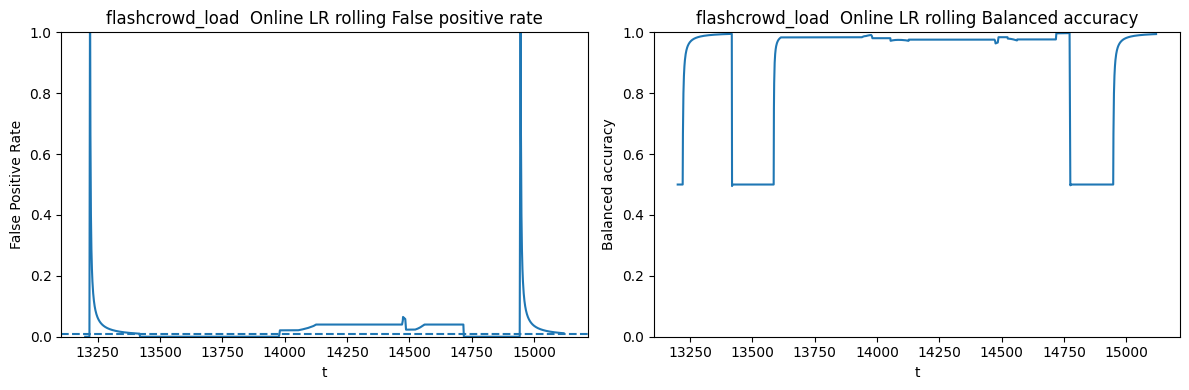

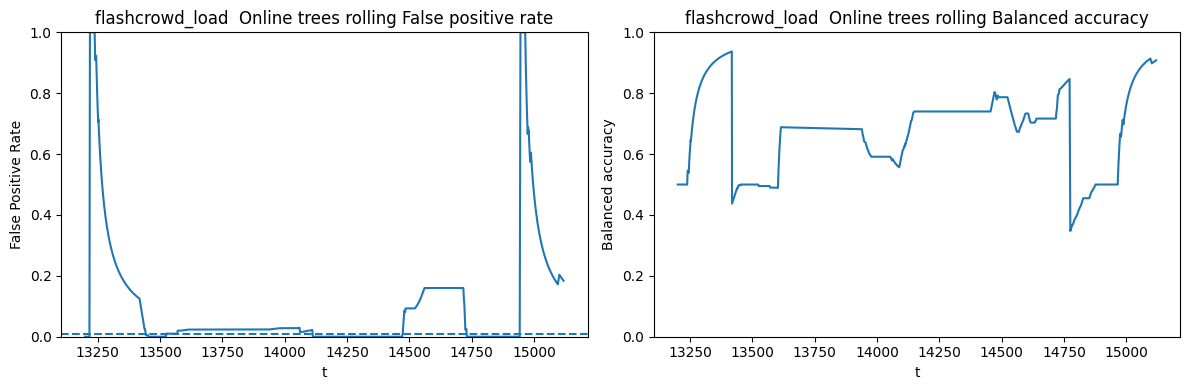

In [ ]:
WROLL = max(200, len(y_test) // 20)

# LR rolling FAR and BA (online)
x_lr, far_lr, ba_lr = rolling_far_ba(
    y=y_test,
    yhat=yhat_test_lr,
    x=t_test,
    window=WROLL,
)
plot_far_ba(
    x_lr,
    far_lr,
    ba_lr,
    title=f"{scenario}  Online LR",
    fpr_cap=0.01,
)

# OAUE rolling FAR and BA (online)
x_oa, far_oa, ba_oa = rolling_far_ba(
    y=y_test,
    yhat=yhat_test_oa,
    x=t_test,
    window=WROLL,
)
plot_far_ba(
    x_oa,
    far_oa,
    ba_oa,
    title=f"{scenario}  Online trees",
    fpr_cap=0.01,
)

**Rolling False Positive Rate and Rolling Balanced Accuracy**

The OAUE Ensamble (online trees) is less stable in some time regions in comparison to online logistic regression. Note that sharp rise at the beginning is warm up of the models, but online logistic regression goes back to 0 much quicker. The OAUE Ensamble definitely needs a proper and careful fine-tuning of the parameters. 

In terms of balanced accuracy, The OAUE Ensamble (online trees) adapts very slowly in comparison to online logistic regression.

In conclusion, literature review played an important informative role and **online logistic regression** should be chosen for this specific dataset and this specific task. My resulst adhere to the theoretical assumptions of the paper ["Predicting  SLA Violations in Real Time using Online Machine Learning"](https://arxiv.org/abs/1509.01386)

